In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import codecs
reload(sys)
sys.setdefaultencoding("utf-8")

In [67]:
# settings
norm = 1  # norm for distance calculation

font = {'fontname':'Century Gothic'}
fontsize = 16

# parties in the Bundestag and their colors according to their wikipedia articles
BTParties = {
    u'DIE LINKE': '#E3000F',
    u'GRÜNE': '#1AA037',
    u'SPD': '#E3000F',
    u'CDU': 'black',
    u'FDP': '#FFED00',
    u'AfD': '#10BAE7'
}

ClusterColors = [
    'magenta',
    'black',
    '#994d00',  # brown
#    '#E3000F',  # red
    '#4d79ff',  # light blue
]

BT = np.array(BTParties.keys())  # parties in Bundestag will get capital markers
Wichtig = np.array([])  # further important parties will get large markers

In [68]:
# read hypotheses and replies
hypfile = 'hypotheses.txt'
repfile = 'replies.txt'

with codecs.open(hypfile, encoding='utf-8') as f:
    Questions = f.read().split('\n')
    Questions = np.array(Questions)
    
with codecs.open(repfile, encoding='utf-8') as f:
    Data = np.loadtxt(f, delimiter=',', 
                      dtype=[('party','U20')]+[('reply_%i' %(i+1),int) for i in xrange(len(Questions))])
Parties = np.array([d[0] for d in Data])
    
V = []
for d in Data:
    V.append(list(d)[1:])
V = np.array(V)
V[V==2] = -1
NP,N = V.shape

In [69]:
# compute distances
D = np.zeros((NP,NP))
for i in xrange(NP):
    for j in xrange(NP):
        D[i,j] = np.linalg.norm(V[i]-V[j],norm)
maxD = 2. * N**(1./norm)
S = (maxD - D)/maxD

In [70]:
# kill diagonal of S
for i in xrange(NP):
    for j in xrange(NP):      
        if j == i:
            S[i,j] = np.nan

In [71]:
# find best k value
#from sklearn.cluster import AffinityPropagation, KMeans
#K = np.arange(1,NP)
#C = []

#for k in K:
#    clustering = KMeans(n_clusters=k, n_init=500).fit(V)
#    C.append(clustering.inertia_)
    
#plt.plot(K,C)

In [72]:
# clustering of V
from sklearn.cluster import AffinityPropagation, KMeans
#clustering = AffinityPropagation().fit(V)
clustering = KMeans(n_clusters=3, n_init=500, random_state=1).fit(V)
ClusterLabels = clustering.labels_

## PCA

In [73]:
def projectPrinc(vec,axis):
    return np.dot(vec,Evec[:,axis])

In [74]:
# principal components
m = np.mean(V,axis=0)
Vm = V - m
#covariance matrix
Cov = np.cov(np.transpose(V))#np.dot(np.transpose(Vm), Vm)
#eigenvalues, eigenvectors
Eval, Evec = np.linalg.eigh(Cov)
#sorting
idx1 = Eval.argsort()[::-1]   
Eval = Eval[idx1]
Evec = -Evec[:,idx1]
d_princ0 = projectPrinc(Vm,0)
d_princ1 = projectPrinc(Vm,1)

In [75]:
def party2D(X, Y):
    for i in xrange(NP):
        x,y = X[i], Y[i]
        partei = Parties[i]
        label = ClusterLabels[i]
        fweight, fsize, textalpha, textcolor = \
                    'normal', fontsize, 0.6, 'grey'
        marker, markersize, color, markeralpha, markeredgecolor = \
                    'o', 0.7*fontsize, ClusterColors[label], 0.6, 'none'
        if partei in BT:
            fweight, fsize, textalpha, textcolor = \
                        'bold', fontsize, 0.9, BTParties[partei]
            marker, markersize, markeralpha = \
                        's', 0.9*fontsize, 0.9
        elif partei in Wichtig:
            fweight, fsize = 'bold',fontsize
            marker, markersize = 's', 0.7*fontsize
        ax.plot(x,y,marker=marker,markersize=markersize,markeredgecolor=markeredgecolor,
                alpha=markeralpha, markeredgewidth=3, color=color)
        ax.text(x,y-0.15, partei, ha='center', va='top', color=textcolor,alpha=textalpha,
                fontsize=fsize,fontweight=fweight,**font)
        
    ax.text(X.max(),Y.min(), 'by /u/askLubich',
            color='black', ha='right', va='bottom',
            fontsize=8,**font)

In [76]:
def wahlergebnis():
    label = 'Nach Wahlergebnis\ngewichtetes Mittel'
    x,y=projectPrinc(ergebnis_mittel,0),projectPrinc(ergebnis_mittel,1)
    ax.plot(x,y,marker='*',markersize=15,markeredgecolor='blue',color='blue')
    ax.text(x,y-0.2, label, ha='center', va='top', color='white',
                fontsize=fontsize-4,**font)

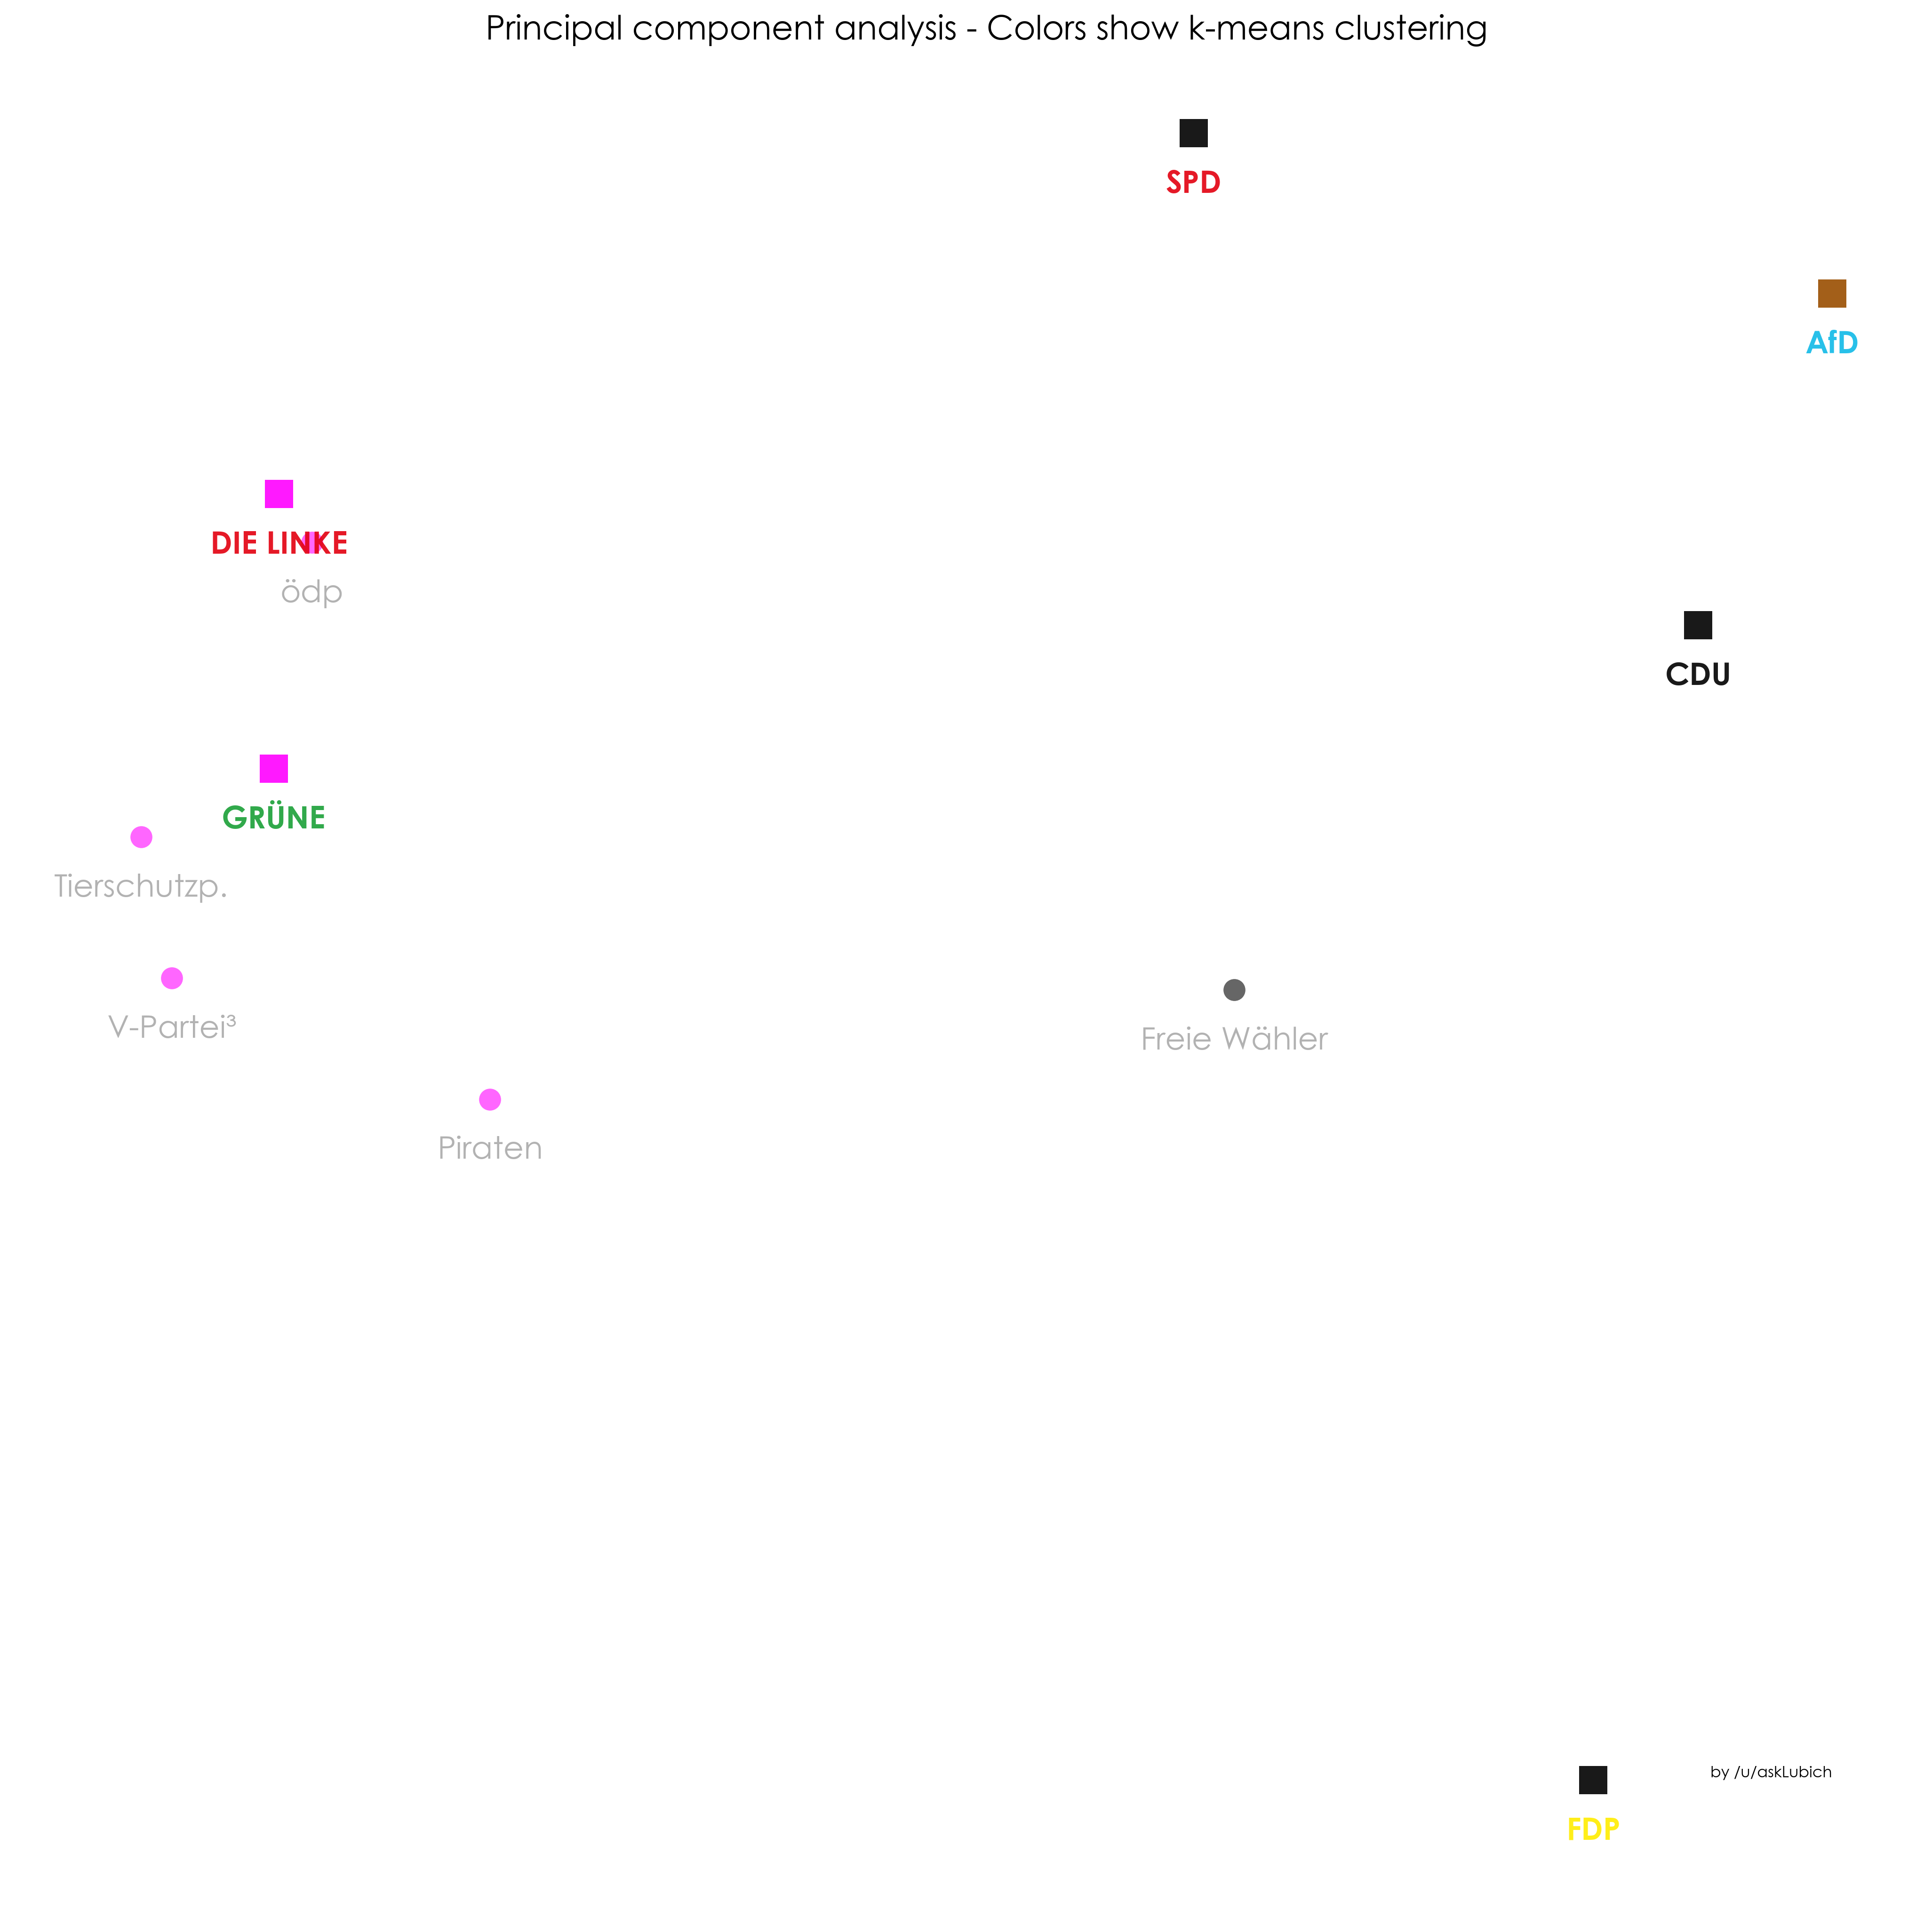

In [77]:
#2D plot
f, ax = plt.subplots(1, figsize=(17,17), dpi=300)
ax.axis('off')
f.patch.set_facecolor('white')
party2D(d_princ0, d_princ1)
ax.set_title('Principal component analysis - Colors show k-means clustering',
             fontsize=fontsize+1,fontweight='normal',**font)
f.show()
f.savefig('2D_PCA.png',bbox_inches='tight', dpi=300,facecolor=f.get_facecolor(), edgecolor='none')

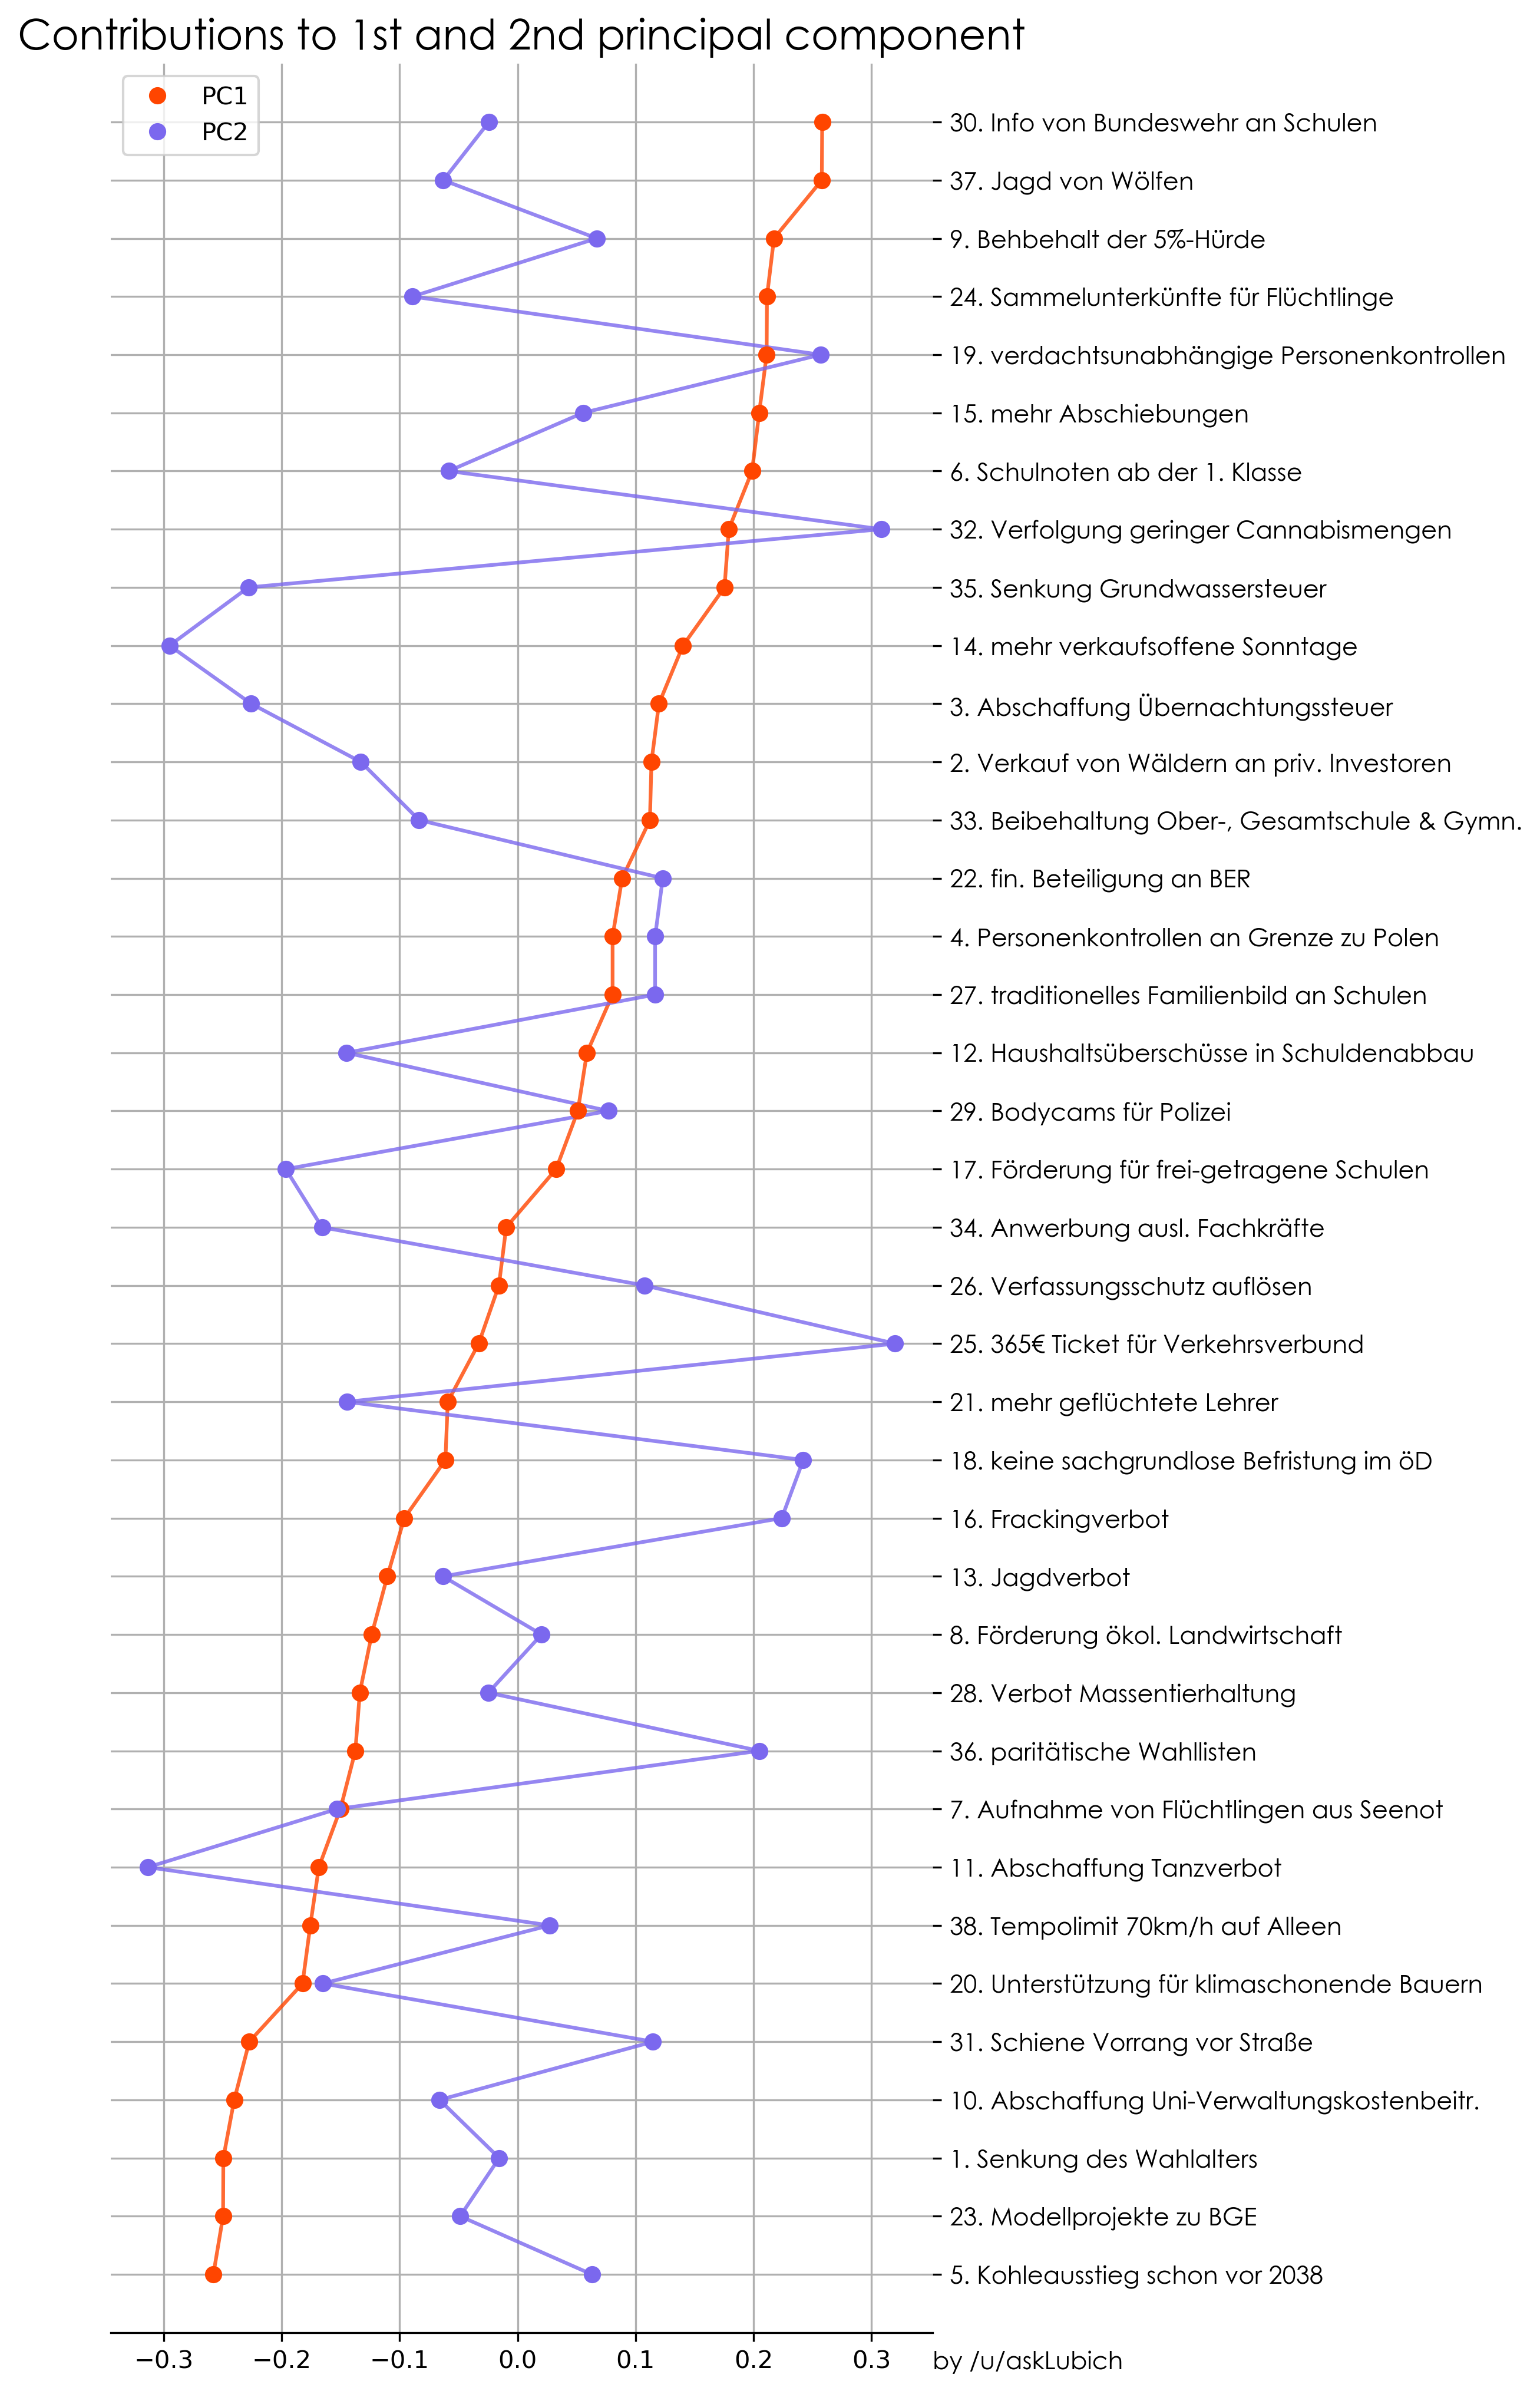

In [78]:
#show contribution to princ. components
QuestionNo = range(len(Questions))

f, ax = plt.subplots(1, figsize=(6,17), dpi=300)
#ax.axis('off')
f.patch.set_facecolor('white')

#sorting
ndx = Evec[:,0].argsort()[::-1]

#plotting
plt.plot(Evec[:,0][ndx],QuestionNo,color='orangered',alpha=0.8)
plt.plot(Evec[:,1][ndx],QuestionNo,color='mediumslateblue',alpha=0.8)
plt.plot(Evec[:,0][ndx],QuestionNo,'o',color='orangered',label='PC1')
plt.plot(Evec[:,1][ndx],QuestionNo,'o',color='mediumslateblue',label='PC2')
ax.yaxis.tick_right()
ax.set_ylim([-1,len(Questions)])
plt.gca().invert_yaxis()
plt.legend(loc='upper left')

#labels
ax.set_yticks(range(len(Questions)))
ax.set_yticklabels(Questions[ndx],**font)
ax.grid()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Contributions to 1st and 2nd principal component',fontsize=fontsize+1,fontweight='normal',**font)
ax.text(ax.get_xlim()[1], ax.get_ylim()[0]+0.3, 
        'by /u/askLubich',color='black',ha='left', va='top',fontsize=10,**font)

f.show()
f.savefig('princCont.png',bbox_inches='tight', dpi=300,facecolor=f.get_facecolor(), edgecolor='none')

## MDS

In [79]:
#do MDS using a force field
def getForces(X,        # current positions
              V,        # current velocities 
              D,        # distance matrix
              k=1.,     # spring constant 
              gamma=0., # friction coefficient
              T=0.,     # temperature in kB
             ):
    nP = len(X)
    F = np.zeros((nP,2))
    W = 0
    
    for i in xrange(nP):
        for j in xrange(i+1,nP):
            difference = X[j] - X[i]            
            distance = np.linalg.norm(difference)
            if distance == 0:
                continue
            direction = difference/distance
            
            f = k* (distance - D[i,j]) * direction
            r = np.sqrt(2*gamma*T) * np.random.normal(loc=0,scale=1)
            F[i] = F[i] + f - gamma*V[i] + r
            F[j] = F[j] - f - gamma*V[j] + r
            W = W + 0.5*k*(distance - D[i,j])**2.
            
    return F,W

def doMinimization(X0,             # initial positions
                   D,              # distance matrix
                   k=1.,           # spring constant
                   dt=1e-2,        # step size
                   maxsteps=1000,  # maximum number of steps
                   epsilon=1e-3    # convergence criterium
                  ):
    #minimize
    X = X0
    V = []
    for t in xrange(maxsteps):
        f, v = getForces(X,np.zeros(X.shape),D,k=k, gamma=0.)
        X = X + dt*f
        V.append(v)
        
        if t%10:
            print 'max-force: %f, energy: %f' %(np.max(f), v)
        
        if t>2 and V[-2]/v-1<epsilon:
            print 'Terminated after %i steps.' %t
            return X, V
        
    return X, V

def doLeapFrog(X0,              # initial positions
               D,               # distance matrix
               M=1.,            # masses
               k=1.,            # spring constant
               gamma=0.,        # friction coefficient
               T=0.,            # temperature in kB
               dt=1e-2,         # time step
               steps=int(1e3),  # number of steps
               dtout=0          # output frequency
              ):
    X = np.copy(X0)
    V = np.zeros(X.shape)
    _, w = getForces(X,V,D,k=k,gamma=gamma,T=T)
    W = [w]
    X_out = [X0]
    
    for t in xrange(steps):
        F, w = getForces(X,V,D,k=k,gamma=gamma,T=T)
        X = X + V * dt
        V = V + (F.T/M).T * dt
        
        if dtout > 0 and not t%dtout:
            X_out.append(np.copy(X))
            W.append(w)
            print 'step %i, energy %f' %(t,w)
    
    if dtout > 0:       
        return X_out, W
    else:
        return X, w

In [80]:
# minimize old results starting from new PCA
X = np.vstack([d_princ0, d_princ1]).T

#scale D to same order of magnitude
scale = np.max(np.std(X,axis=0))    
D_scaled = D * 2.*scale/np.mean(D[D>0])
D_scaled = D * 2.*scale/np.mean(D[D>0])

X, W = doMinimization(X, D_scaled, epsilon=1e-10)

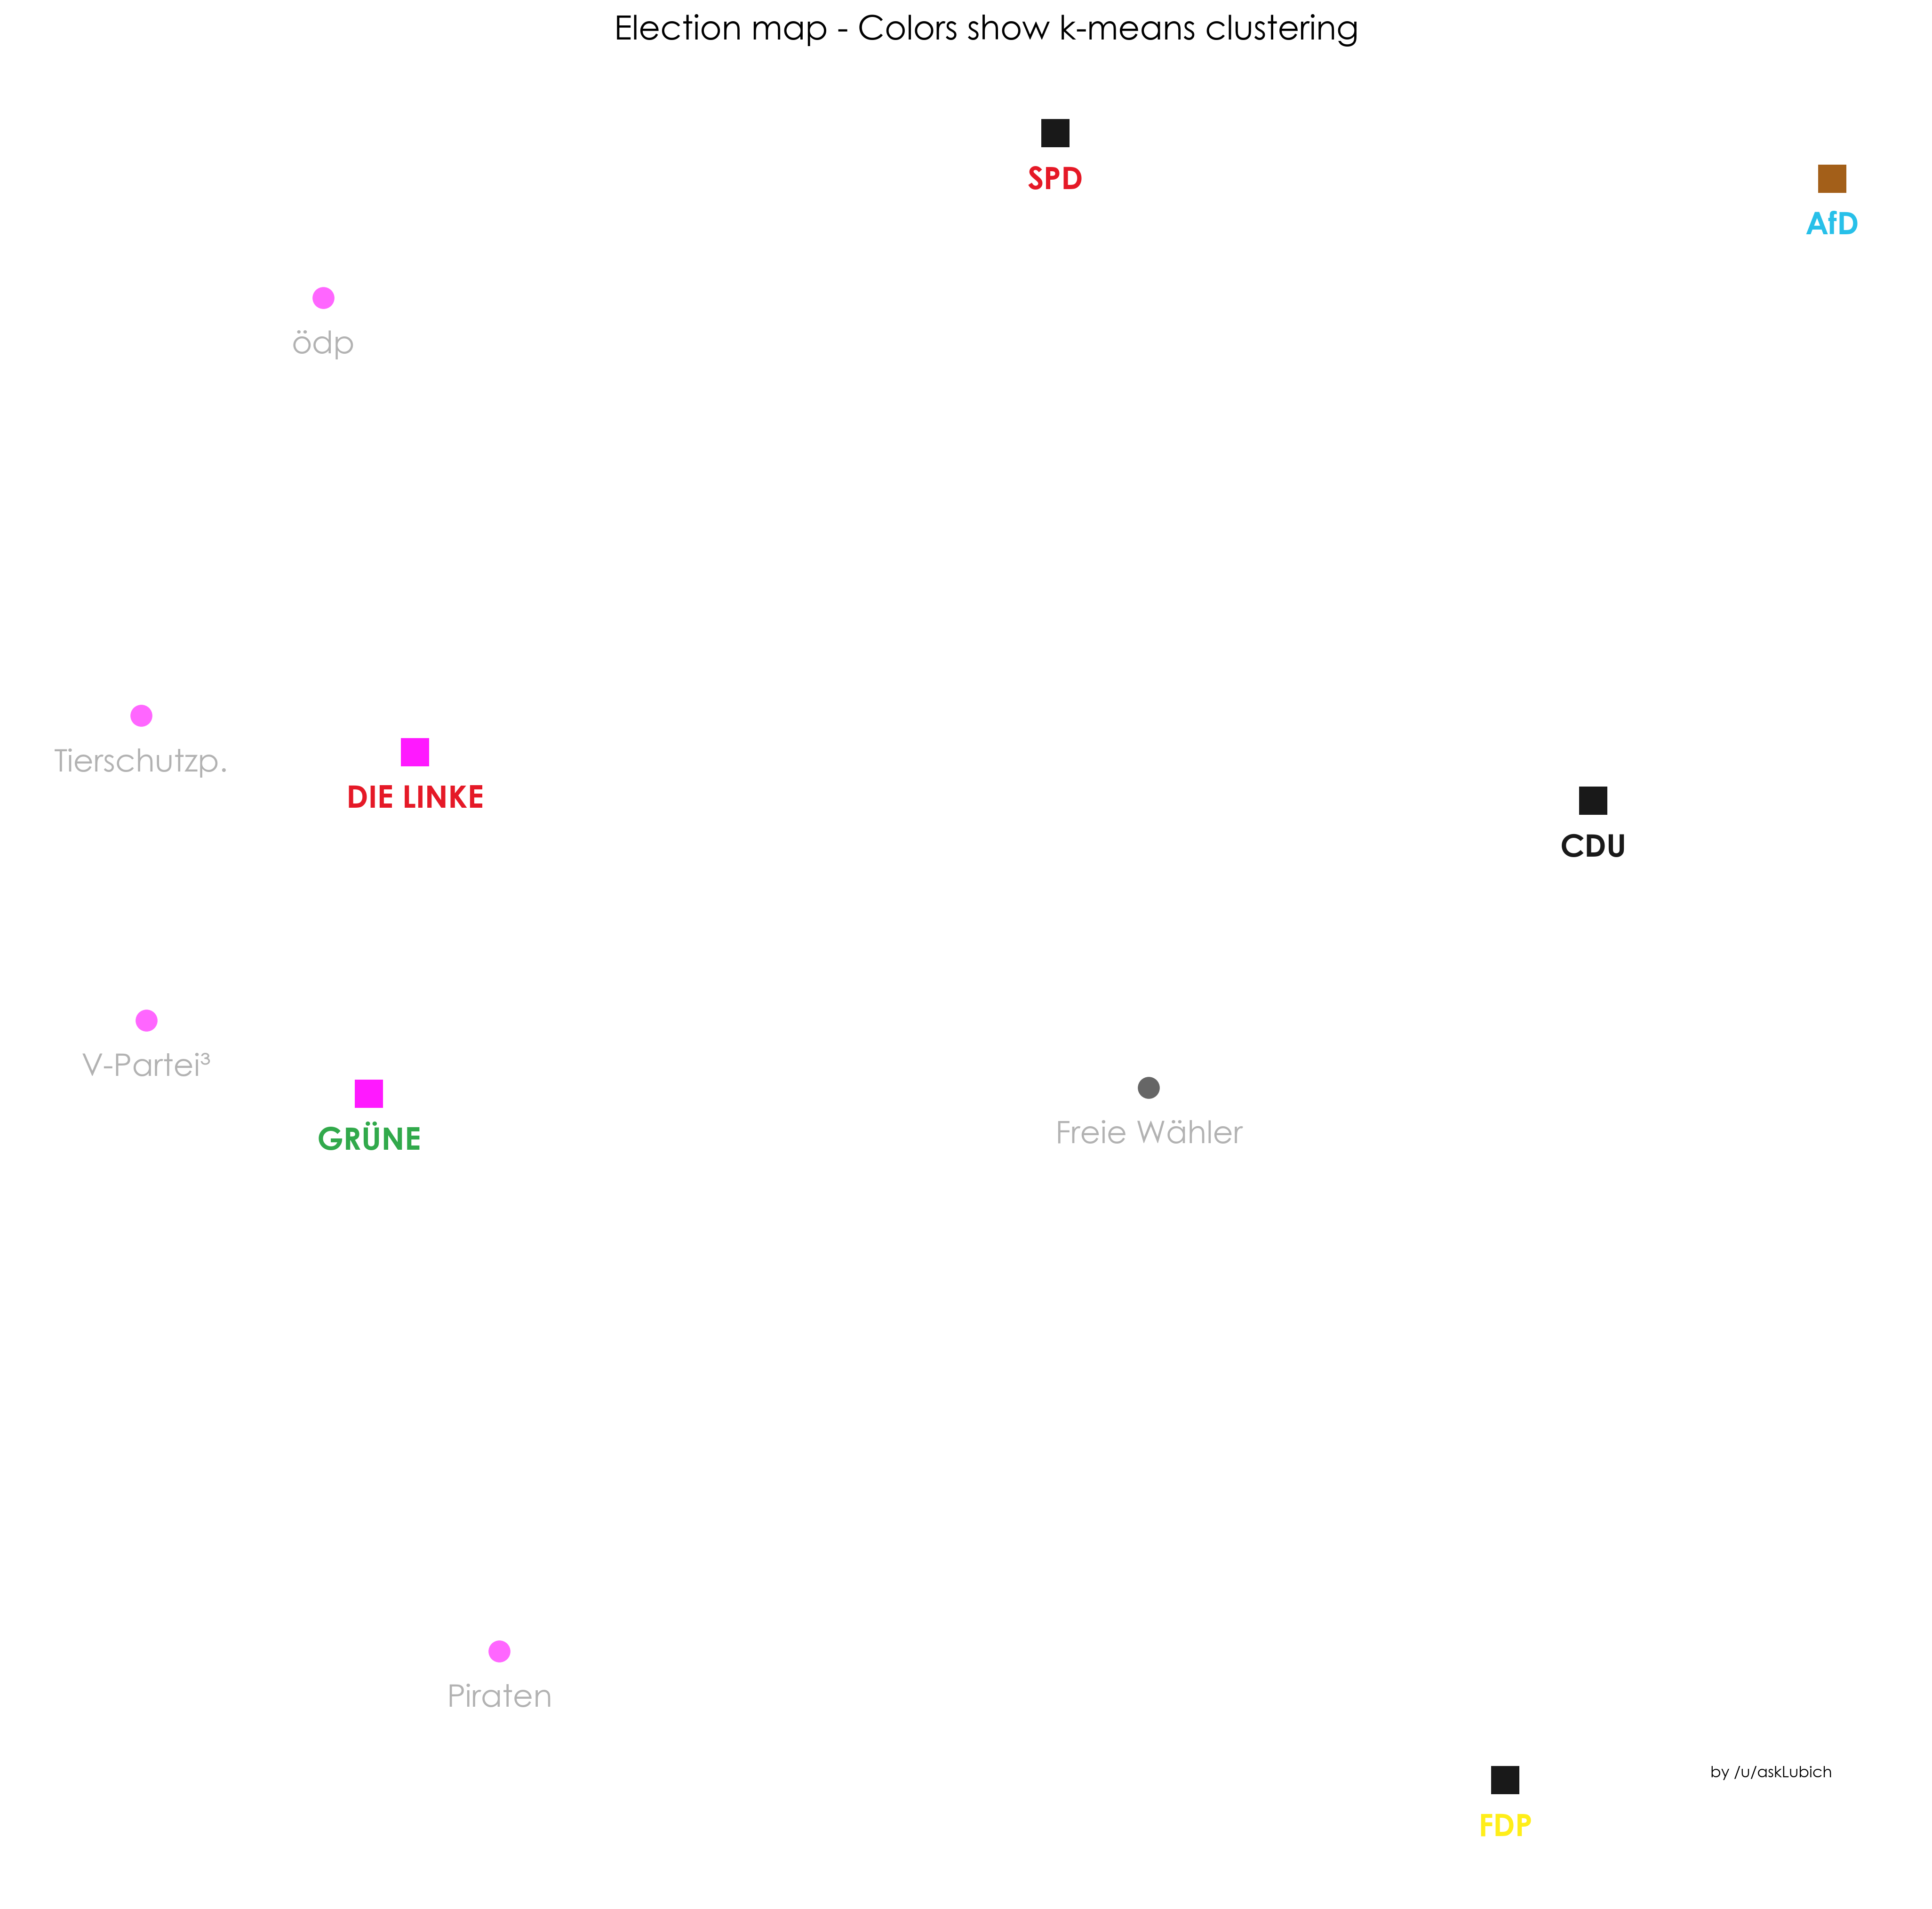

In [81]:
#2D plot
f, ax = plt.subplots(1, figsize=(17,17), dpi=300)
ax.axis('off')
f.patch.set_facecolor('white')
party2D(X[:,0], X[:,1])
ax.set_title('Election map - Colors show k-means clustering',
             fontsize=fontsize+1,fontweight='normal',**font)
f.show()
f.savefig('2D_MDS.png',bbox_inches='tight', dpi=300,facecolor=f.get_facecolor(), edgecolor='none')

## Matrix

In [82]:
Title = u'Agreement of German Parties running for the Brandenburg election\naccording to the Wahl-O-Mat (in %)'
cmap = 'coolwarm'

In [83]:
#sorting according to 1st principle axis
idx2 = d_princ0.argsort()
Parties_sort = Parties[idx2]
S_sort = S[idx2,:]
S_sort = S_sort[:,idx2]
ClusterLabels_sort = ClusterLabels[idx2]

In [84]:
def partylabel():
    for j in xrange(NP):
        partei = Parties_sort[j]
        if partei in BT:
            fweight = 'bold'
            color = BTParties[partei]
        else:
            fweight = 'normal'
            color = 'grey'
        clustercolor = ClusterColors[ClusterLabels_sort[j]]
        #xlabels
        txt = ax.text(j, -0.65, partei, ha='center', va='bottom', color=color,
                fontsize=fontsize,rotation=-90,fontweight=fweight,**font)        
        ax.text(j, NP-0.35, partei, ha='center', va='top', color=clustercolor,
                fontsize=fontsize,rotation=90,fontweight=fweight,**font)
        #ylabels
        ax.text(-0.6, j, partei, ha='right', va='center', color=color,
                fontsize=fontsize,fontweight=fweight,**font)
        ax.text(NP-0.35, j, partei, ha='left', va='center', color=clustercolor,
                fontsize=fontsize,fontweight=fweight,**font)

In [85]:
import matplotlib.patheffects as PathEffects
def labels():
    for i in xrange(NP):
        for j in xrange(NP):
            if i!=j:
                if Parties_sort[i] in BT or Parties_sort[j] in BT:
                    weight = 'bold'
                else:
                    weight = 'normal'
                txt = ax.text(j, i, '%d' % round(S_sort[i,j]*100), ha='center',
                        va='center', color='white',fontsize=fontsize,fontweight=weight,**font)
                txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='grey')])

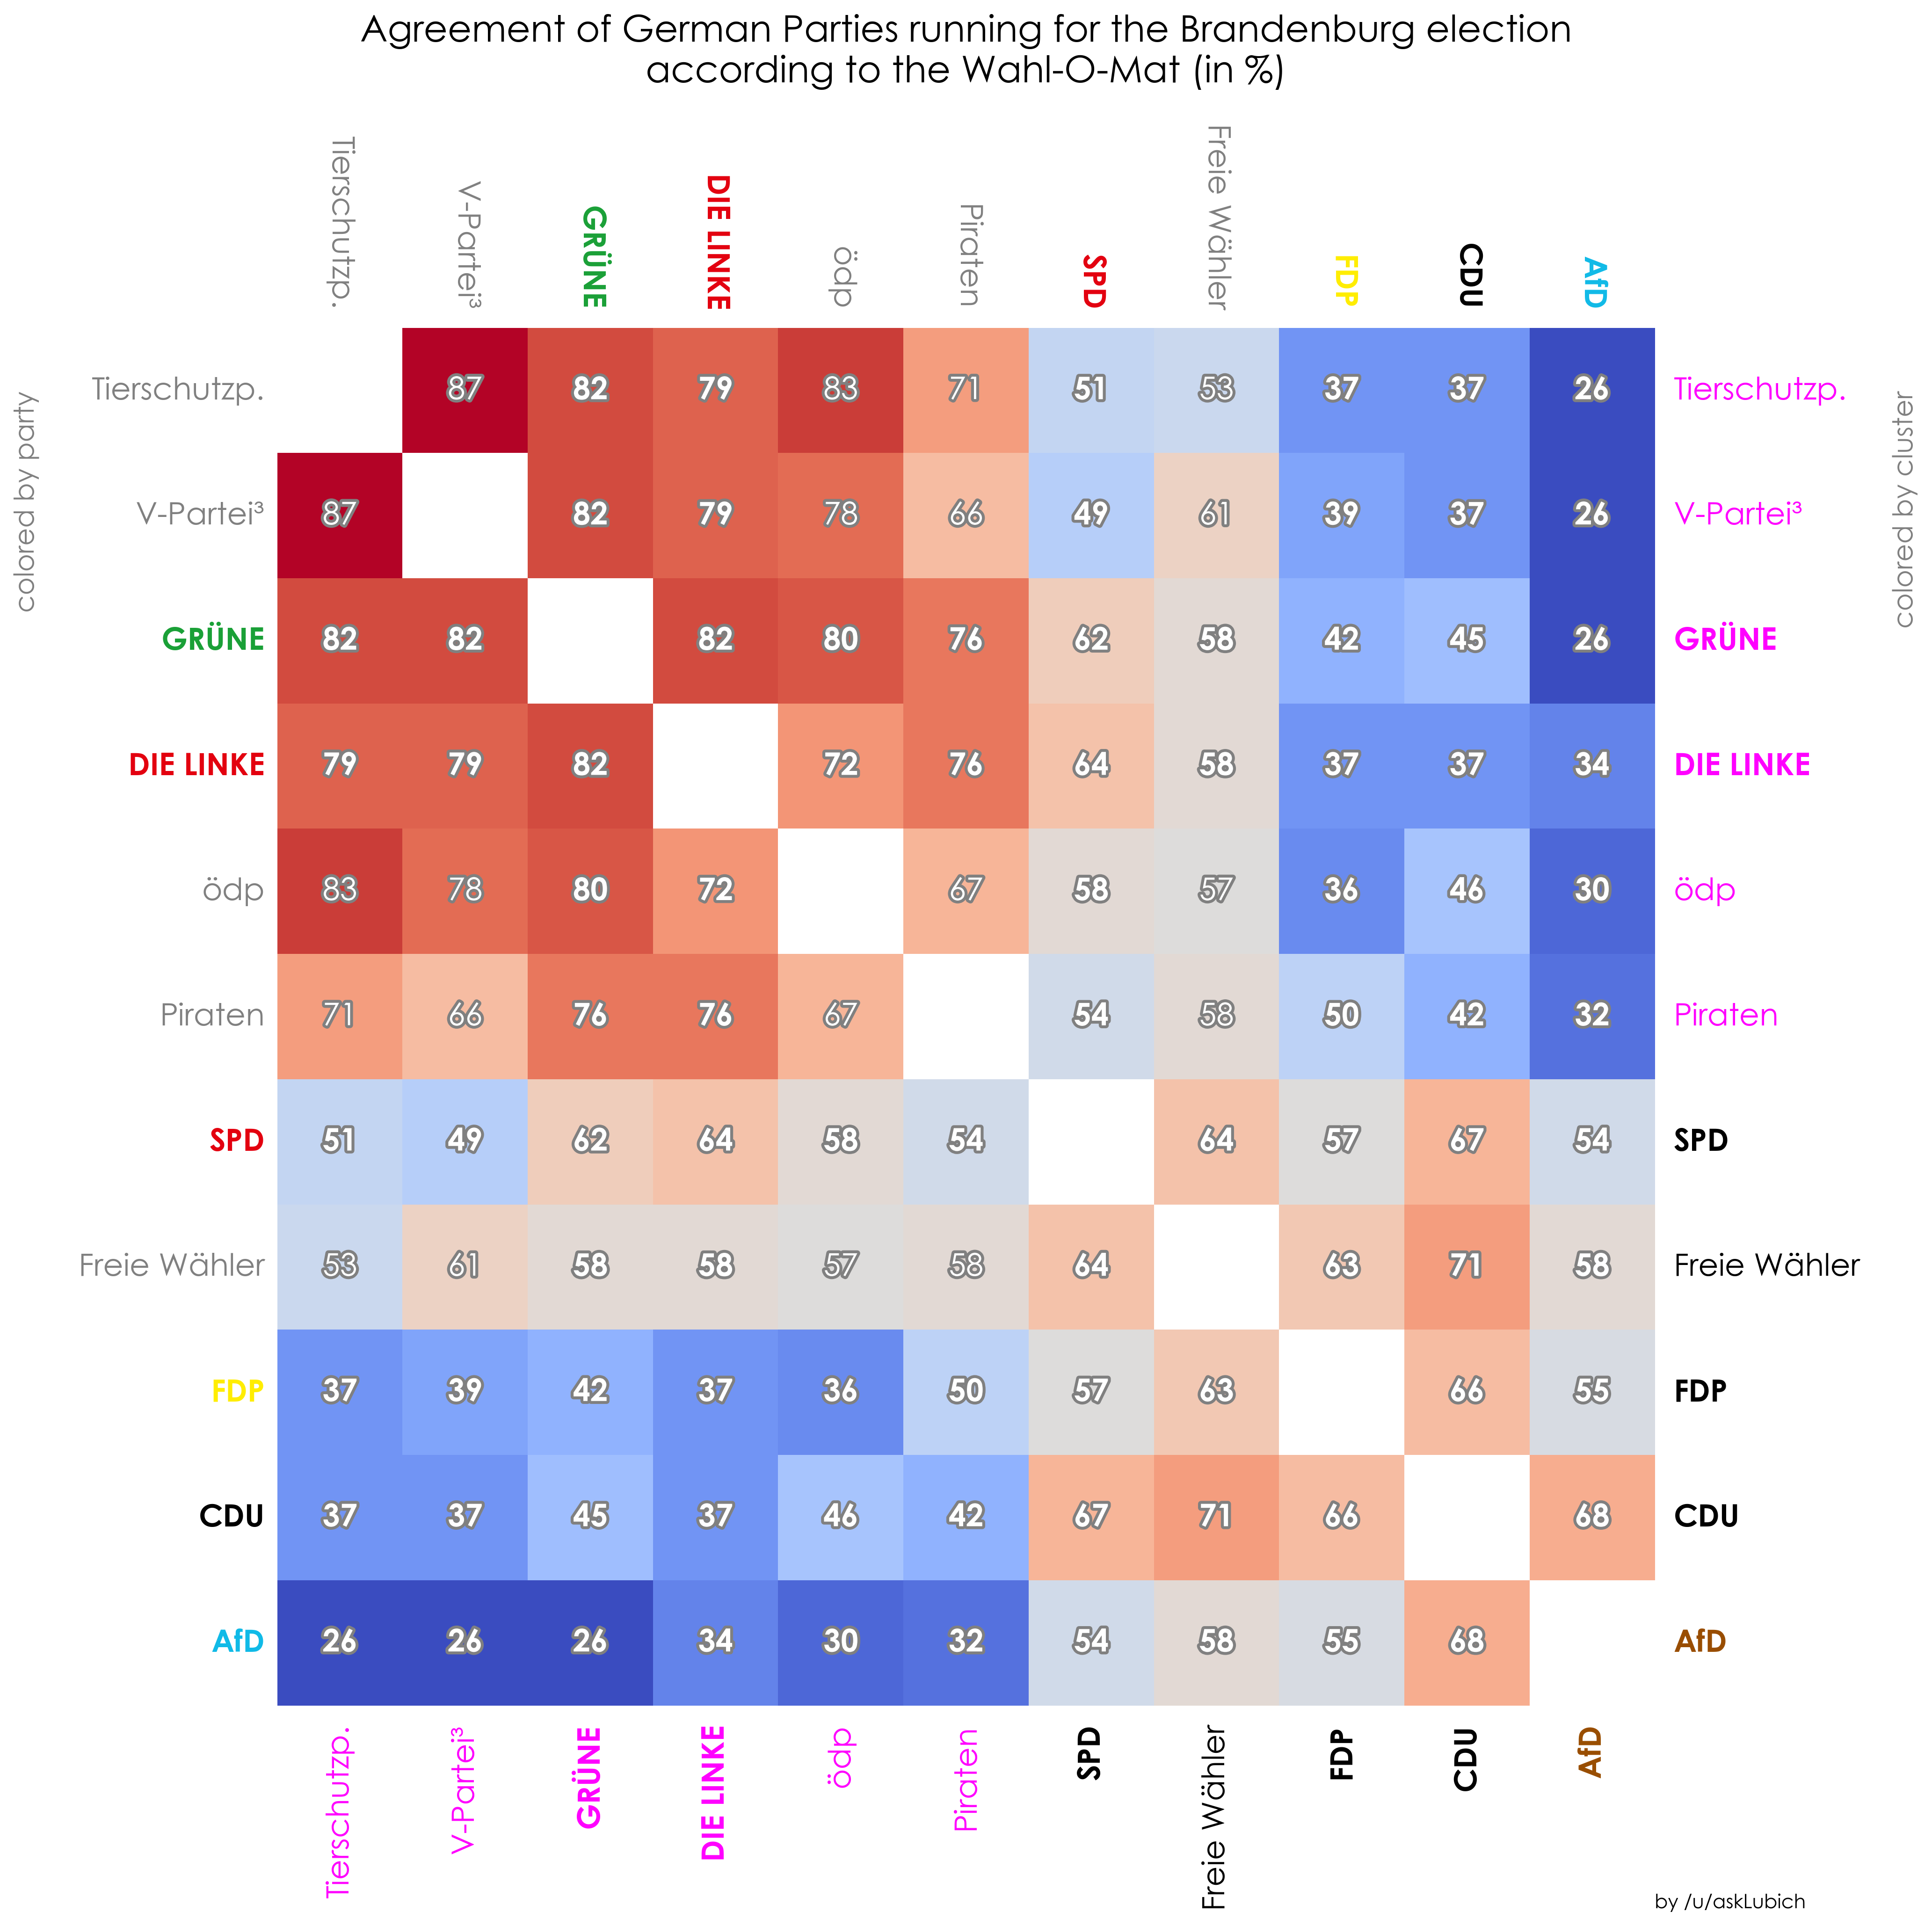

In [86]:
f, ax = plt.subplots(1, figsize=(13, 13), dpi=300, facecolor='white')
ax.imshow(S_sort,interpolation='none',cmap=cmap)#, vmin=0, vmax=1)
ax.axis('off')
partylabel()
labels()
ax.text(NP-0.5,NP+1, 'by /u/askLubich', ha='left', va='top',fontsize=10,**font)
ax.text(NP+1.5,0, 'colored by cluster', ha='center', va='top', rotation=90,
        fontsize=fontsize-2, color='grey', **font)
ax.text(-2.5,0, 'colored by party', ha='center', va='top', rotation=90,
        fontsize=fontsize-2, color='grey', **font)
ax.set_title(Title,position=(0.5,1.17),fontsize=fontsize+3,fontweight='normal',**font)
f.show()
f.savefig('wahlomat.png',bbox_inches='tight', dpi=300)